In [91]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/ac1jjgg/MOGP_GPyTorch/FiveCancersDataSet/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/GPyTorch_Models/Dataset_BRAF/GDSC2/"

In [92]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

In [93]:
#df = pd.read_csv(_FOLDER + "GDSC2_melanoma_BRAF.csv")  # dataset prepared by Subhashini-Evelyn
#df_drug = pd.read_csv(_FOLDER + "GDSC2_Drug_Features.csv")  

In [94]:
name_for_KLrelevance = 'GDSC2_melanoma_BRAF.csv'

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

# Here we just check that from the column index 25 the input features start
start_pos_features = 25
print(df_train_No_MolecForm.columns[start_pos_features])

#print("Columns with std equal zero:")
#print("Number of columns with zero std:", np.sum(df_train_No_MolecForm.std(0) == 0.0))
#print(np.where(df_train_No_MolecForm.std(0) == 0.0))
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

ABCB1_mut
Columns with std equal zero:
Number of columns with zero std: 707
(array([   2,    4,    5,    6,   11,   12,   24,   25,   26,   27,   28,
         29,   32,   34,   35,   36,   38,   40,   41,   43,   44,   45,
         47,   52,   53,   54,   56,   59,   60,   61,   62,   66,   67,
         68,   69,   70,   71,   74,   77,   78,   79,   80,   81,   83,
         84,   85,   86,   87,   90,   91,   92,   93,   94,   96,   98,
        100,  101,  102,  104,  107,  109,  111,  112,  113,  115,  116,
        117,  118,  119,  120,  121,  122,  124,  126,  127,  128,  129,
        130,  131,  132,  133,  134,  136,  137,  139,  140,  141,  143,
        144,  145,  146,  147,  148,  149,  150,  151,  153,  154,  156,
        157,  158,  159,  161,  162,  163,  166,  167,  168,  169,  170,
        172,  173,  174,  175,  177,  178,  179,  182,  186,  187,  189,
        190,  191,  194,  195,  196,  197,  198,  200,  201,  202,  203,
        204,  207,  208,  209,  210,  211,  212

''

In [95]:
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])

y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, 8):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

(357, 1)
Ytrain size:  (357, 7)


0.5800247704071014


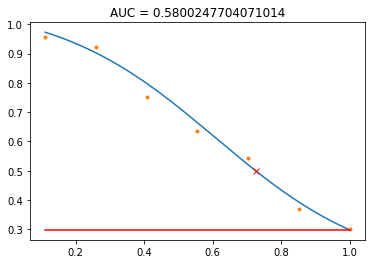

In [172]:
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):
    params_4_sig_train = np.concatenate(
        (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import matplotlib.pyplot as plt
from sklearn import metrics

plt.close('all')

x_lin = np.linspace(0.111111, 1, 1000)
x_real_dose = np.linspace(0.111111, 1, 7)  #Here is 7 due to using GDSC2 that has 7 doses
x_lin_tile = np.tile(x_lin, (params_4_sig_train.shape[0], 1))
# (x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res = []
AUC = []
IC50 = []
Ydose50 = []
Emax = []
for i in range(params_4_sig_train.shape[0]):
    Ydose_res.append(sigmoid_4_param(x_lin_tile[i, :], *params_4_sig_train[i, :]))
    AUC.append(metrics.auc(x_lin_tile[i, :], Ydose_res[i]))
    Emax.append(Ydose_res[i][-1])
    res1 = (Ydose_res[i] < 0.507)
    res2 = (Ydose_res[i] > 0.493)
    if (res1 & res2).sum() > 0:
        Ydose50.append(Ydose_res[i][res1 & res2].mean())
        IC50.append(x_lin[res1 & res2].mean())
    elif Ydose_res[i][-1]<0.5:
        Ydose50.append(Ydose_res[i].max())
        IC50.append(x_lin[ np.where(Ydose_res[i].max())[0]])
    else:
        Ydose50.append(0.5)
        IC50.append(1.5) #IC50.append(x_lin[-1])

posy = 300
#plt.figure(Nfold)
plt.plot(x_lin, Ydose_res[posy])
plt.plot(x_real_dose, y_train_drug[posy, :], '.')
plt.plot(IC50[posy], Ydose50[posy], 'rx')
plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
plt.title(f"AUC = {AUC[posy]}")
print(AUC[posy])

In [173]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# Compute Log(AUC)? R/ Not for Functional Random Forest Model
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
ind_nonzero_std = np.where(X_train_features.std(0)!=0.0)[0]
AllNames_Features = df_train_No_MolecForm.columns[start_pos_features:]  #starts from 25
Name_Features_Melanoma = AllNames_Features[ind_nonzero_std]
Xall = X_train_features[:,ind_nonzero_std].copy()
Yall = y_train_drug.copy()

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

AUC train size: (357, 1)
IC50 train size: (357, 1)
Emax train size: (357, 1)
X all data size: (357, 419)
Y all data size: (357, 7)


''